In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.25.1
numpy==1.17.2
matplotlib==3.1.1


In [3]:
df = pd.read_csv('Coinbase_BTCUSD_1_d.csv')
df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,2018-04-23,BTCUSD,8795.01,8991.00,8775.10,8931.30,7780.82,6.921474e+07
1,2018-04-24,BTCUSD,8931.30,9728.56,8930.00,9648.00,19437.27,1.815242e+08
2,2018-04-25,BTCUSD,9648.00,9763.49,8602.43,8865.98,29386.63,2.698941e+08
3,2018-04-26,BTCUSD,8865.98,9318.00,8660.00,9272.11,14759.34,1.314352e+08
4,2018-04-27,BTCUSD,9272.11,9369.00,8910.00,8922.55,11378.78,1.045393e+08


In [4]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [5]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 1000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 132.621800
iter 20. reward: 157.007600
iter 30. reward: 193.678800
iter 40. reward: 209.016400
iter 50. reward: 392.207900
iter 60. reward: 306.232500
iter 70. reward: 234.942600
iter 80. reward: 345.111600
iter 90. reward: 382.266800
iter 100. reward: 353.544200
iter 110. reward: 426.042000
iter 120. reward: 514.312000
iter 130. reward: 527.453400
iter 140. reward: 508.044300
iter 150. reward: 503.113600
iter 160. reward: 546.974000
iter 170. reward: 506.454100
iter 180. reward: 493.506800
iter 190. reward: 447.448500
iter 200. reward: 467.433500
iter 210. reward: 469.051000
iter 220. reward: 482.477200
iter 230. reward: 564.847700
iter 240. reward: 628.351000
iter 250. reward: 672.987000
iter 260. reward: 670.231100
iter 270. reward: 715.573000
iter 280. reward: 716.135800
iter 290. reward: 651.237300
iter 300. reward: 637.652800
iter 310. reward: 647.944500
iter 320. reward: 718.896400
iter 330. reward: 713.253900
iter 340. reward: 773.070000
iter 350. reward: 734.2

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 1 unit at price 8931.300000, total balance 1068.700000
day 1, sell 1 unit at price 9648.000000, investment 8.024588 %, total balance 10716.700000,
day 2: buy 1 unit at price 8865.980000, total balance 1850.720000
day 3, sell 1 unit at price 9272.110000, investment 4.580768 %, total balance 11122.830000,
day 4: buy 1 unit at price 8922.550000, total balance 2200.280000
day 8, sell 1 unit at price 9072.290000, investment 1.678220 %, total balance 11272.570000,
day 10: buy 1 unit at price 9725.740000, total balance 1546.830000
day 13, sell 1 unit at price 9600.000000, investment -1.292858 %, total balance 11146.830000,
day 20: buy 1 unit at price 8686.100000, total balance 2460.730000
day 22, sell 1 unit at price 8477.460000, investment -2.401999 %, total balance 10938.190000,
day 24: buy 1 unit at price 8059.000000, total balance 2879.190000
day 28, sell 1 unit at price 8393.440000, investment 4.149895 %, total balance 11272.630000,
day 34: buy 1 unit at price 7346.640000, tot

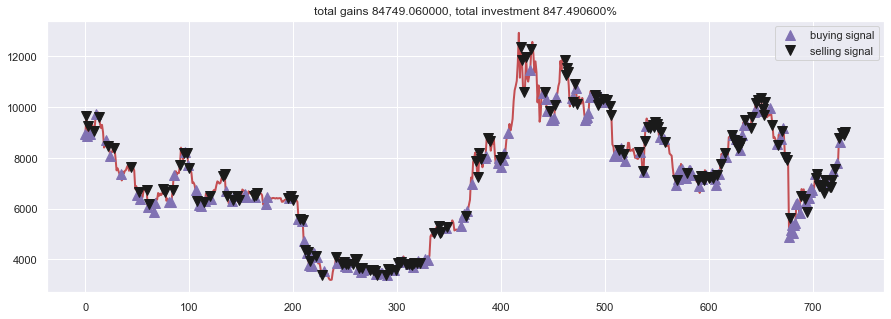

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()